In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [37]:
!pip install -q kaggle

In [38]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [39]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d fccuser/2021-new-coder-survey

  0% 0.00/1.82M [00:00<?, ?B/s]
100% 1.82M/1.82M [00:00<00:00, 69.9MB/s]


In [40]:
!unzip 2021-new-coder-survey.zip

Archive:  2021-new-coder-survey.zip
replace 2021 New Coder Survey.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2021 New Coder Survey.csv  


In [41]:
data = pd.read_csv("/content/2021 New Coder Survey.csv")

<ipython-input-41-ab0317492a73>:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/2021 New Coder Survey.csv")


In [42]:
data.keys()

Index(['Timestamp', '1. What is your biggest reason for learning to code?',
       '2. What methods have you used to learn about coding? Please select all that apply.',
       '3. Which online learning resources have you found helpful? Please select all that apply.',
       '4. If you have attended in-person coding-related events before, which ones have you found helpful? Please select all that apply.',
       '5. If you have listened to coding-related podcasts before, which ones have you found helpful? Please select all that apply.',
       '6. If you have watched coding-related YouTube videos before, which channels have you found helpful? Please select all that apply.',
       '7. About how many hours do you spend learning each week?',
       '8. About how many months have you been programming?',
       '9. Aside from university tuition, about how much money have you spent on learning to code so far (in US Dollars)?',
       '10. Are you already employed in a software development job

In [43]:
df = pd.DataFrame(columns=['Age', 'HoursCoded', 'Gender',  'Degree','Income'])
df['HoursCoded'] = data.iloc[:, 7]
df['Age'] = data.iloc[:, 23]
df['Gender'] = data.iloc[:, 24]
df['Degree'] = data.iloc[:, 33]
df['Income'] = data.iloc[:, 22]


df.head()

,Age,HoursCoded,Gender,Degree,Income
0,33.0,4.0,Prefer not to say,"Computer science, computer engineering, or sof...",NaN
1,38.0,10.0,Male,"Environmental science (e.g., earth sciences, s...","Under $1,000"
2,NaN,30.0,Male,Art,NaN
3,19.0,NaN,Male,"Another engineering discipline (e.g., civil, e...",NaN
4,35.0,2.0,Male,"Computer science, computer engineering, or sof...","$40,000 to $49,999"


**DATA CLEANING**

In [44]:
#Data Cleaning


def multiple_imputer(df):
  df_copy = df.copy()
  df_copy = df.copy()
  numerical_columns = ['Age', 'HoursCoded']
  imputer = IterativeImputer(max_iter=10, random_state=0)
  df_copy[numerical_columns] = imputer.fit_transform(df_copy[numerical_columns])
  return df_copy

In [45]:
imputed_df = multiple_imputer(df)

In [46]:
imputed_df.head()

,Age,HoursCoded,Gender,Degree,Income
0,33.000000,4.000000,Prefer not to say,"Computer science, computer engineering, or sof...",NaN
1,38.000000,10.000000,Male,"Environmental science (e.g., earth sciences, s...","Under $1,000"
2,26.496081,30.000000,Male,Art,NaN
3,19.000000,13.157355,Male,"Another engineering discipline (e.g., civil, e...",NaN
4,35.000000,2.000000,Male,"Computer science, computer engineering, or sof...","$40,000 to $49,999"


**EDA**

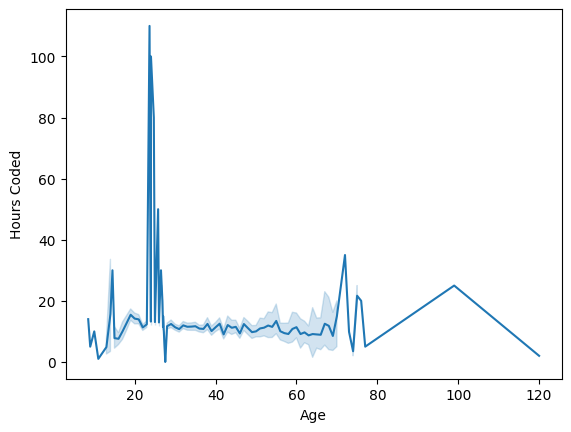

In [121]:
#AgeV/SHoursCoded
sns.lineplot(data=imputed_df, x='Age', y='HoursCoded')
plt.xlabel('Age')
plt.ylabel('Hours Coded')
plt.show()

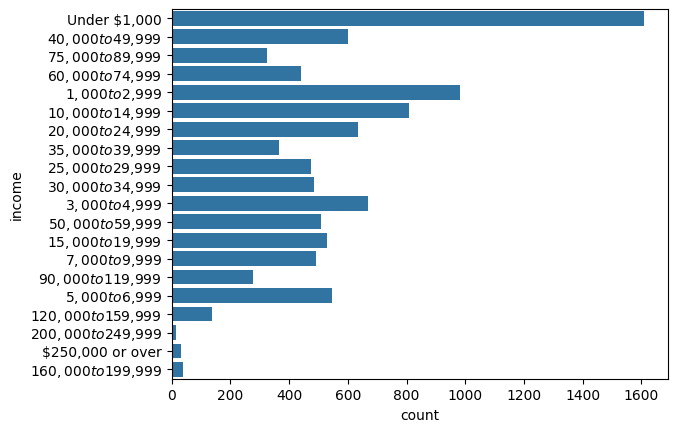

In [123]:
#Income's Countplot
sns.countplot(y=imputed_df['Income'], data=imputed_df)
plt.xlabel("count")
plt.ylabel("income")
plt.show()

In [50]:
print(imputed_df.columns)

Index(['Age', 'HoursCoded', 'Gender', 'Degree', 'Income', 'high_income'], dtype='object')


In [53]:
#Cleaning the Income feature
# Removing "I don’t know" and "I don't want to answer" and nan values for cleaner operations
# and Mapping function to convert income categories to binary values
def mapping(income_str):
    if pd.isnull(income_str) or income_str == "I don’t know" or income_str == "I don't want to answer":
        return np.nan  # Mark as NaN if it's one of the specified values
    elif income_str == "Under $1,000" or income_str == "$1,000 to $2,999" or income_str == "$3,000 to $4,999" or income_str == "$5,000 to $6,999" or income_str == "$7,000 to $9,999" or income_str == "$10,000 to $14,999" or income_str == "$15,000 to $19,999" or income_str == "$20,000 to $24,999" or income_str == "$25,000 to $29,999":
        return 0
    else:
        return 1

# Apply mapping function to the income column
imputed_df['high_income'] = imputed_df['Income'].apply(mapping)

imputed_df.dropna(subset=['high_income'], inplace=True)

<ipython-input-54-75a7fe51fe20>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="right") # For better visualization


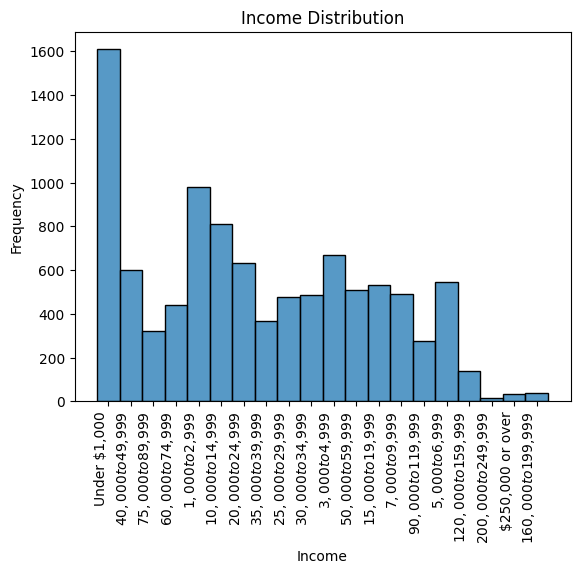

In [54]:
# Visualize the distributions for the Income
ax = sns.histplot(imputed_df['Income'], bins=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, ha="right") # For better visualization
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

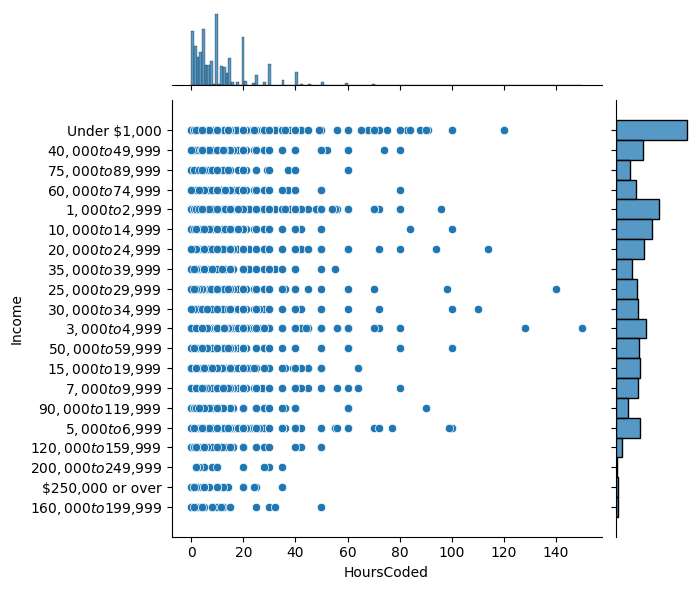

In [124]:
#IncomevSHoursCoded Joint Plot
sns.jointplot(x=imputed_df['HoursCoded'], y=imputed_df['Income'], kind="scatter")
plt.xlabel('HoursCoded')
plt.ylabel('Income')
plt.show()

In [56]:
imputed_df.keys()

Index(['Age', 'HoursCoded', 'Gender', 'Degree', 'Income', 'high_income'], dtype='object')

In [57]:
imputed_df.head()

,Age,HoursCoded,Gender,Degree,Income,high_income
1,38.0,10.0,Male,"Environmental science (e.g., earth sciences, s...","Under $1,000",0.0
4,35.0,2.0,Male,"Computer science, computer engineering, or sof...","$40,000 to $49,999",1.0
5,27.0,10.0,Male,"Computer science, computer engineering, or sof...","$75,000 to $89,999",1.0
6,24.0,5.0,Male,"A business discipline (e.g., accounting, finan...","$60,000 to $74,999",1.0
7,23.0,20.0,Male,"Another engineering discipline (e.g., civil, e...","$1,000 to $2,999",0.0


In [58]:
df = imputed_df.drop(columns=['Income', 'Gender'])


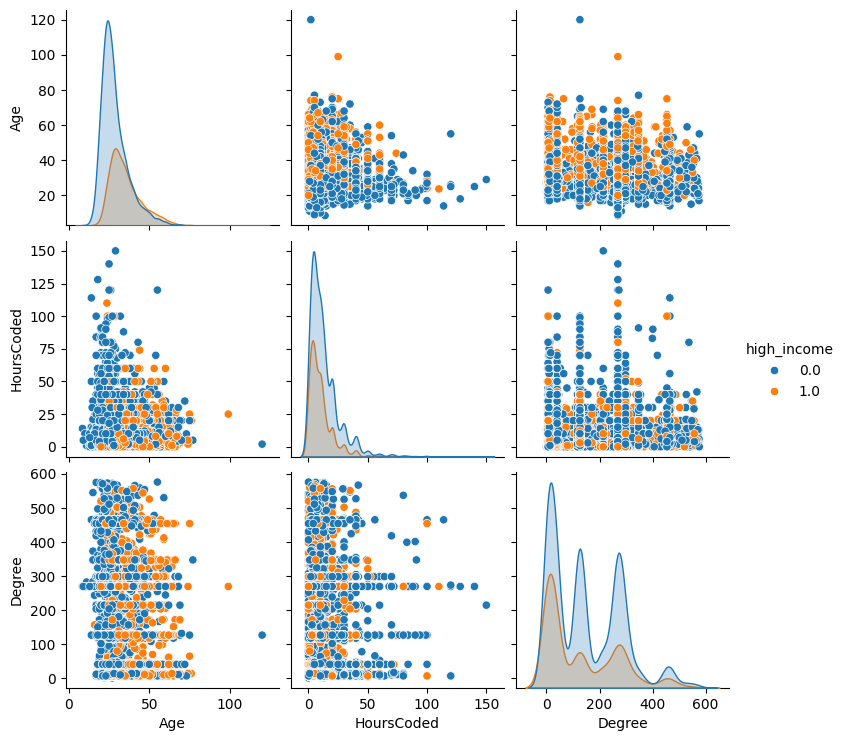

In [125]:
#PairPlot Among Features over High_Income

sns.pairplot(df, diag_kind='kde', hue='high_income')
plt.show()

In [126]:
object_cols = []
for col in df.columns:
    if (df[col].dtype == 'object'):
        object_cols.append(col)

In [128]:


encoder = OrdinalEncoder()

In [130]:
# Encoding values
encoded_data = df
encoded_data[object_cols] = encoder.fit_transform(df[object_cols])
encoded_data = pd.DataFrame(encoded_data,columns = df.columns)

In [131]:
features = [x for x in df.columns]

# Calculate Pearson correlation coefficients between features and target variable
correlation_matrix = df[features].corr(method='pearson')
print("Pearson Correlation Matrix:", correlation_matrix)

correlation = correlation_matrix['high_income'].abs()
correlation_sorted = correlation.sort_values(ascending=False)

# the correlated features in Descending order
top_features = correlation_sorted[0:10].index.tolist()
print("\nTop 50 Features (based on Pearson correlation with 'high_income'):")
for i, feature in enumerate(top_features, start=1):
    print(f"{i}. {feature}")

Pearson Correlation Matrix:                   Age  HoursCoded    Degree  high_income
Age          1.000000   -0.051597 -0.063581     0.329200
HoursCoded  -0.051597    1.000000  0.014460    -0.108179
Degree      -0.063581    0.014460  1.000000    -0.064494
high_income  0.329200   -0.108179 -0.064494     1.000000

Top 50 Features (based on Pearson correlation with 'high_income'):
1. high_income
2. Age
3. HoursCoded
4. Degree


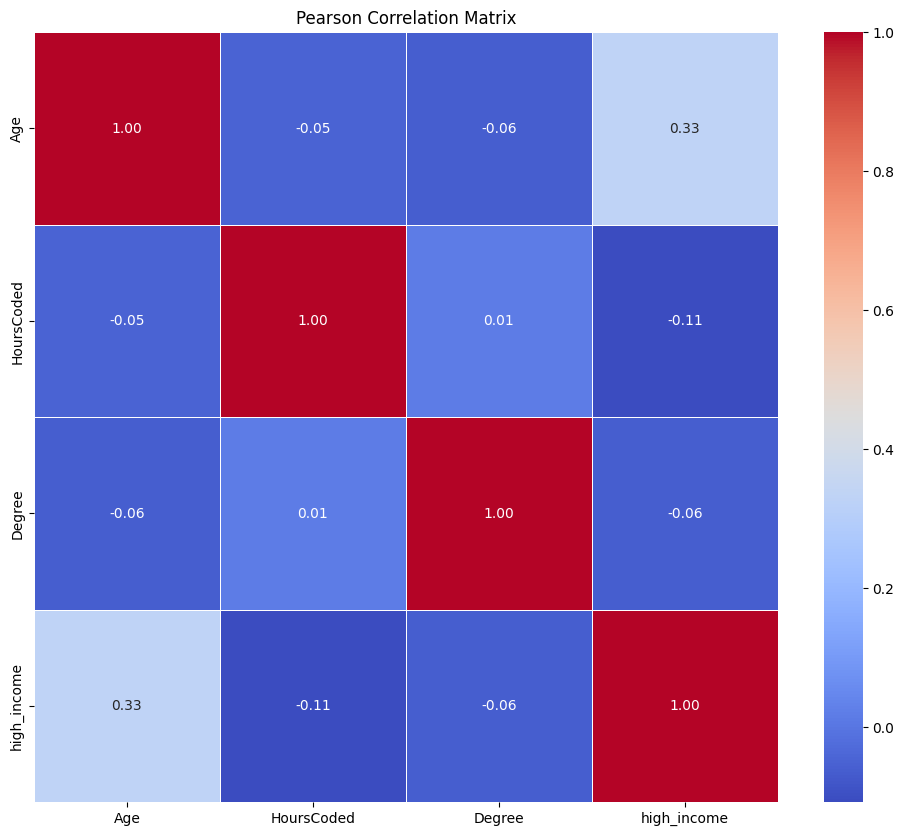

In [132]:
plt.figure(figsize = (12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()

**CLUSTER ANALYSIS**

In [133]:
top_10 = top_features[0:10]

In [134]:
X = encoded_data[top_10]
Y = encoded_data['high_income']

In [135]:



imputer = KNNImputer(n_neighbors = 2)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

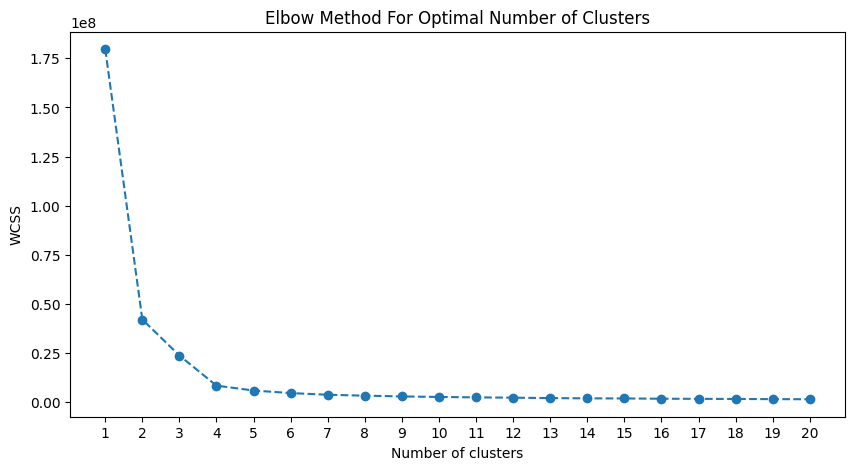

In [136]:

# Within cluster sum of squares
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_imputed)
    #Sum of Distance of sample
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Diagram
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 21))
plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


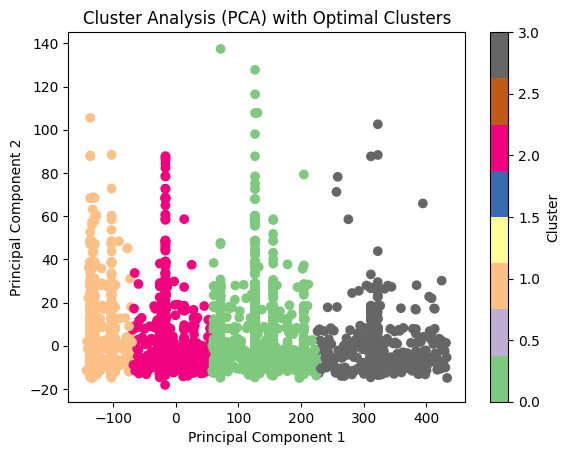

In [137]:
optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_imputed)

# Visualizing Clusters with PCA Reduction
pca = PCA(n_components=3) # Reducing to 3 components for visualization
reduced_data = pca.fit_transform(X_imputed)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='Accent')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Analysis (PCA) with Optimal Clusters')
plt.colorbar(label='Cluster')
plt.show()


**Model Development and Training**

In [83]:
X_train,X_test,y_train,y_test = train_test_split(X_imputed,Y,test_size = 0.3,random_state = 42)

In [96]:
logistic_regression = LogisticRegression()
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

logistic_param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100]
}
knn_param_grid = {'n_neighbors': [3,5,7]}
tree_param_grid = {'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 5, 10]}
forest_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_leaf': [1, 5, 10]}

logistic_cv = RandomizedSearchCV(logistic_regression, logistic_param_grid, cv=5)
knn_cv = RandomizedSearchCV(knn, knn_param_grid, cv=5)
decision_tree_cv = RandomizedSearchCV(decision_tree, tree_param_grid, cv=5)
random_forest_cv = RandomizedSearchCV(random_forest, forest_param_grid, cv=5)

In [105]:
logistic_cv.fit(X_train, y_train)
knn_cv.fit(X_train, y_train)
decision_tree_cv.fit(X_train, y_train)
random_forest_cv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 5, 10],
                                        'min_samples_leaf': [1, 5, 10],
                                        'n_estimators': [50, 100, 200]})

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.91      0.81      2034
         1.0       0.60      0.27      0.37       956

    accuracy                           0.71      2990
   macro avg       0.66      0.59      0.59      2990
weighted avg       0.69      0.71      0.67      2990

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.81      0.77      2034
         1.0       0.50      0.41      0.45       956

    accuracy                           0.68      2990
   macro avg       0.62      0.61      0.61      2990
weighted avg       0.66      0.68      0.67      2990

Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      2034
         1.0       0.54      0.45      0.49       956

    accuracy                           0.70      2990
   macro avg      

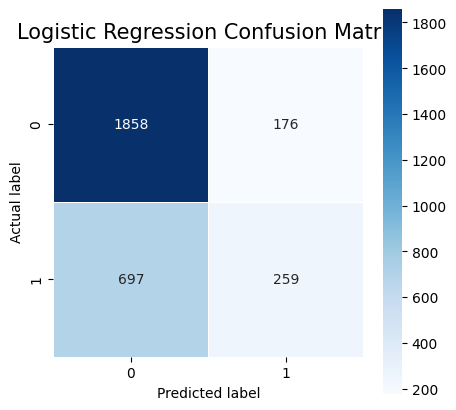

In [106]:
# Predictions
y_pred_logistic = logistic_cv.predict(X_test)
y_pred_knn = knn_cv.predict(X_test)
y_pred_decision_tree = decision_tree_cv.predict(X_test)
y_pred_random_forest = random_forest_cv.predict(X_test)

# Classification Reports
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_decision_tree))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_random_forest))

# Confusion Matrices - Example for Logistic Regression
cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Logistic Regression Confusion Matrix', size=15)
plt.show()




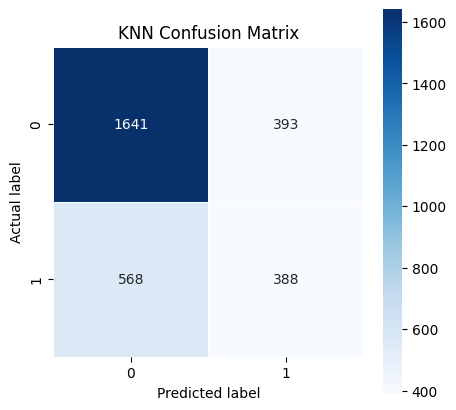

In [107]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_knn, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('KNN Confusion Matrix')
plt.show()

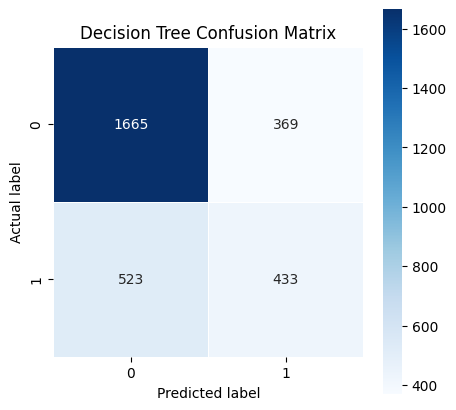

In [108]:

cm_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_decision_tree, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Decision Tree Confusion Matrix')
plt.show()


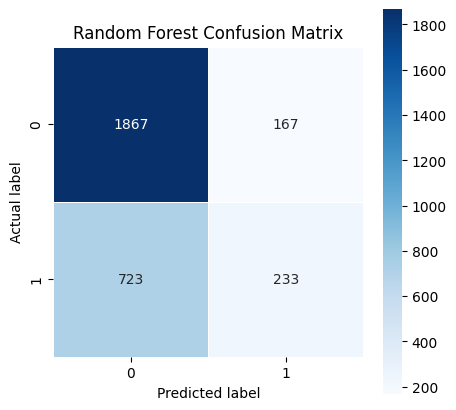

In [109]:
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_random_forest, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Random Forest Confusion Matrix')
plt.show()

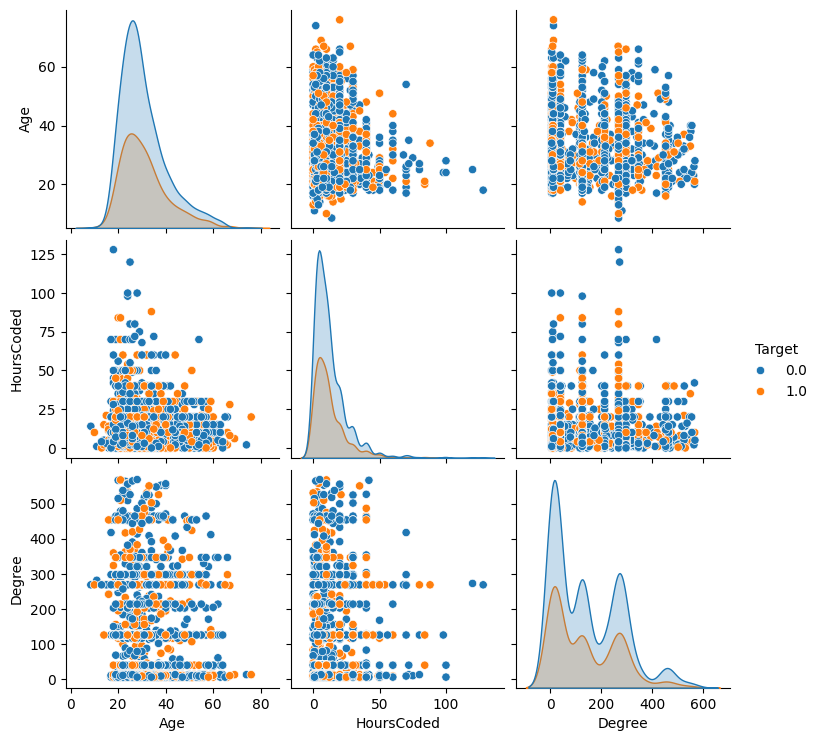

In [116]:
import seaborn as sns


data_for_plot = X_train.copy()
data_for_plot['Target'] = y_train

sns.pairplot(data_for_plot, hue='Target', diag_kind='kde')
plt.show()

In [99]:
# Best parameters
logistic_params = logistic_cv.best_params_
knn_params = knn_cv.best_params_
dt_params = decision_tree_cv.best_params_

print("Logistic Regression Best Parameters:", logistic_params)
print("KNN Best Parameters:", knn_params)
print("Decision Tree Best Parameters:", dt_params)

Logistic Regression Best Parameters: {'C': 0.01}
KNN Best Parameters: {'n_neighbors': 7}
Decision Tree Best Parameters: {'min_samples_leaf': 10, 'max_depth': 5}


In [101]:
#performance before the tuning of hyperparameters

log_acc_bef = logistic_regression.fit(X_train, y_train).score(X_test, y_test)
knn_acc_bef = knn.fit(X_train, y_train).score(X_test, y_test)
decision_tree_acc_bef = decision_tree.fit(X_train, y_train).score(X_test, y_test)
print("\n Performance Before Tuning:")
print("Logistics Regression Accuracy :", log_acc_bef)
print("KNN Accuracy:", knn_acc_bef)
print("Decision Tree Accuracy:", decision_tree_acc_bef)



 Performance Before Tuning:
Logistics Regression Accuracy : 0.7080267558528428
KNN Accuracy: 0.6695652173913044
Decision Tree Accuracy: 0.6397993311036789


In [102]:
# Performance after tuning
logistic_acc_aft = logistic_cv.score(X_test, y_test)
knn_acc_aft = knn_cv.score(X_test, y_test)
decision_tree_acc_aft = decision_tree_cv.score(X_test, y_test)

print("\nPerformance After Tuning:")
print("Logistic Regression Accuracy:", logistic_acc_aft)
print("KNN Accuracy:", knn_acc_aft)
print("Decision Tree Accuracy:", decision_tree_acc_aft)


Performance After Tuning:
Logistic Regression Accuracy: 0.7080267558528428
KNN Accuracy: 0.6785953177257525
Decision Tree Accuracy: 0.7016722408026755


**ENSEMBLE METHODS**

In [110]:


adaboost = AdaBoostClassifier()
gradient_boosting = GradientBoostingClassifier()

In [111]:
# Hyperparameter grids for tuning
adaboost_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
gradient_boosting_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 10]}

# Hyperparameter tuning
adaboost_cv = RandomizedSearchCV(adaboost, adaboost_param_grid, cv=5)
gradient_boosting_cv = RandomizedSearchCV(gradient_boosting, gradient_boosting_param_grid, cv=5)

In [112]:
# Fit the models
adaboost_cv.fit(X_train, y_train)
gradient_boosting_cv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 1],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [50, 100, 200]})

In [113]:

# Best parameters
adaboost_params = adaboost_cv.best_params_
gradient_boosting_params = gradient_boosting_cv.best_params_

print("AdaBoost Best Parameters:", adaboost_params)
print("Gradient Boosting Best Parameters:", gradient_boosting_params)



AdaBoost Best Parameters: {'n_estimators': 50, 'learning_rate': 1}
Gradient Boosting Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


In [114]:
# Performance before tuning
adaboost_accuracy_before = adaboost.fit(X_train, y_train).score(X_test, y_test)
gradient_boosting_accuracy_before = gradient_boosting.fit(X_train, y_train).score(X_test, y_test)

print("\nPerformance Before Tuning:")
print("AdaBoost Accuracy:", adaboost_accuracy_before)
print("Gradient Boosting Accuracy:", gradient_boosting_accuracy_before)



Performance Before Tuning:
AdaBoost Accuracy: 0.703010033444816
Gradient Boosting Accuracy: 0.7040133779264214


In [115]:
# Performance after tuning
adaboost_accuracy_after = adaboost_cv.score(X_test, y_test)
gradient_boosting_accuracy_after = gradient_boosting_cv.score(X_test, y_test)

print("\nPerformance After Tuning:")
print("AdaBoost Accuracy:", adaboost_accuracy_after)
print("Gradient Boosting Accuracy:", gradient_boosting_accuracy_after)



Performance After Tuning:
AdaBoost Accuracy: 0.703010033444816
Gradient Boosting Accuracy: 0.7120401337792642
